**In this file we use Translation DeepSentiPers Dataset for binary SA**


# Prepare  sys

## check GPU

In [ ]:
!nvidia-smi #The NVIDIA System Management Interface (nvidia-smi) is a command line utility,
            # intended to aid in the management and monitoring of NVIDIA GPU devices. 

Tue Jul  6 11:25:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install required packages

In [ ]:
!pip install -q transformers==3

!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 757kB 7.7MB/s 
     |████████████████████████████████| 901kB 14.6MB/s 
     |████████████████████████████████| 3.0MB 35.2MB/s 
     |████████████████████████████████| 1.2MB 51.0MB/s 
     |████████████████████████████████| 317kB 7.4MB/s 
     |████████████████████████████████| 235kB 12.8MB/s 
     |████████████████████████████████| 1.4MB 13.9MB/s 
     |████████████████████████████████| 133kB 10.0MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 245kB 24.0MB/s 


## Import required packages

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import requests
import os
import io
import re
import json
import copy
import collections

# Translation Dataset

We are going to use [Translation DeepSentiPers Dataset](https://github.com/JoyeBright/DeepSentiPers/tree/master/Dataset) here.

<table style="width:100%">
  <tr>
    <th>Polarity</th>
    <th>-2</th>
    <th>-1</th>
    <th>0</th>
    <th>+1</th>
    <th>+2</th>
  </tr>
  <tr>
    <td>Original (SentiPers) DS</td>
    <td>28</td>
    <td>513</td>
    <td>2409</td>
    <td>1623</td>
    <td>988</td>
  </tr>
  <tr>
    <td>Translation DS</td>
    <td>56</td>
    <td>1026</td>
    <td>4818</td>
    <td>3246</td>
    <td>1976</td>
  </tr>
</table>



## Load

In [ ]:
url = "https://raw.githubusercontent.com/JoyeBright/DeepSentiPers/master/Dataset/translation.csv" 
download = requests.get(url).content
data = pd.read_csv(io.StringIO(download.decode('utf-8')))
data.set_axis(['comment', 'rate'], axis='columns', inplace=True)
print('The first 5 rows of the dataset: \n', data.head())

The first 5 rows of the dataset: 
                                              comment  rate
0  کارتهای حافظه معمولاً در تلفنهای همراه به جای ...     0
1          وضوح نمایشگر iPod دقیقاً مشابه آیفون است.     0
2  اما صفحه نمایش JVC GZ-MG335 از نوع TFT 2.7 این...     0
3  سرانجام ، در پشت گوشی ، دوربین از یک فلاش بلند...     0
4  در انتهای گوشی ، ایسوس درگاهی را به نام MHL قر...     0


In [ ]:
# print data information
print('data information: \n')
print(data.info(), '\n')

data information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14045 entries, 0 to 14044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  14045 non-null  object
 1   rate     14045 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 219.6+ KB
None 



## Preprocessing

The comments have different lengths based on words! Detecting the most normal range could help us find the maximum length of the sequences for the preprocessing step.

In [ ]:
# calculate the length of comments based on their words
data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

In [ ]:
min_max_lenT = data["comment_len_by_words"].min(), data["comment_len_by_words"].max()
print(f'Min of Translation DS: {min_max_lenT[0]} \tMax Translation T DS: {min_max_lenT[1]}')

Min of Translation DS: 1 	Max Translation T DS: 281


In [ ]:
Rec = 0
for j in range(len(data)):
  if (data.iloc[j]['comment_len_by_words'] < 3):
    Rec = Rec + 1
    print(data.iloc[j]['comment'],data.iloc[j]['rate'],)
print(Rec, ' records found with upper comments')

دارای 264 0
موفق باشید 0
قدیمی است 0
موفق باشید 0
بسیار قوی 0
فرومایه 0
مشاهده کام 0
سلام. 0
پخش HD 0
سلام 0
سلام. 0
سلام. 0
موفق باشید 0
فروشگاه برنامه 0
با تشکر 0
با تشکر 0
دوربین نیست 0
قضاوت شماست 0
با تشکر 0
دارای 264 0
شیک زیبا 1
خیلی باحال 1
داشتنش خوبه 1
مرسی دیجیکالا 1
عالی 1
سرعت خوب 1
قیمت مناسب 1
کالای عالی 1
خارق العاده 1
کامل 1
بهتر بود 1
داغ نیست 1
رنگهای واضح 1
موفق باشید 1
بدون کنه 1
واقعاً زیباست 1
عالی بود 1
بد نیست 1
خیلی بزرگ 1
کامل. 1
چه جالب 1
لمس عالی 1
آویزان نیست 1
شکرگذاری 1
آویزان نیست 1
بهترین گوشه 1
کامل 2
دوربین عالی 2
سرعت عالی 2
عالیه! 2
بسیار جذاب 2
عالی. 2
خیلی راحت 2
تلفن زیبا 2
منحصر بفرد 2
عالیه. 2
واقعا عالیه 2
واقعا عالیه 2
سلام. 2
تلفن عالی 2
عجیب 2
صدای عالی 2
واقعا عالیه 2
عالی بود 2
عالیه! 2
خیلی کوچک 2
عالیه 2
عالی 2
واقعا عالیه 2
دوباره عالی 2
واقعا عالیه 2
واقعا خوب 2
عالیه 2
عالیه 2
عالیه 2
کالای عالی 2
واقعا قشنگه 2
عالیه. 2
خیلی خوب 2
عالیه. 2
واقعا عالیه 2
عالیه 2
خیلی خوب 2
واقعا خوبه 2
توقف کار 2
فردی است 2
عالیه 2
واقعاً شیک 2
عالی!

In [ ]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [ ]:
data_gl_than(data, 256, 2)

Texts with word length of greater than 2 and less than 256 includes 99.00% of the whole!


Seems Texts with word length of greater than 2 and less than 256 includes 99% of the whole! so we can omit the others to have better dataset.

In [ ]:
minlim, maxlim = 2, 256

In [ ]:
# remove comments with the length beetween 2 and 256 
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim <= len_t <= maxlim else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14027 entries, 0 to 14026
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               14027 non-null  object 
 1   rate                  14027 non-null  int64  
 2   comment_len_by_words  14027 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.9+ KB


In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['comment_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within comments in Translation DS',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
unique_rates = list(sorted(data['rate'].unique()))
print(f'We have #{len(unique_rates)} in translation DS:: {unique_rates}')

We have #5 in translation DS:: [-2, -1, 0, 1, 2]


In [ ]:
fig = go.Figure()

groupby_rate = data.groupby('rate')['rate'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Binarization DS using NR approch

NR: Removing neutral emotions

To a binary form of negative (0) or positive (1) with a threshold. If the rate is greater than 0, it labeled as positive otherwise specified as negative.

In [ ]:
# remove the 0 rate recordes from DS
data['rate'] = data['rate'].apply(lambda r: r if r != 0 else None)

data = data.dropna(subset=['rate'])
data = data.dropna(subset=['comment'])

data = data.drop_duplicates(subset=['comment'], keep='first')
data = data.reset_index(drop=True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9138 entries, 0 to 9137
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               9138 non-null   object 
 1   rate                  9138 non-null   float64
 2   comment_len_by_words  9138 non-null   float64
dtypes: float64(2), object(1)
memory usage: 214.3+ KB


In [ ]:
def rate_to_label(rate):
    if rate < 1:
        return 'negative'
    else:
      return 'positive'


In [ ]:
data['label'] = data['rate'].apply(lambda r: rate_to_label(r))
labels = list(sorted(data['label'].unique()))

data.head()

,comment,rate,comment_len_by_words,label
0,همچنین یک برنامه کاربردی بسیار مفید برای ارائه...,1.0,10.0,positive
1,این استاندارد بدان معنی است که دستگاه نسبت به ...,1.0,28.0,positive
2,در حقیقت هنگام معرفی دوربین ، قابلیت بزرگنمایی...,1.0,26.0,positive
3,این گوشی از رابط کاربری TimeScape سونی اریکسون...,1.0,23.0,positive
4,در مرور اواسط روز Wi-Fi ، رایانه لوحی توانست ب...,1.0,16.0,positive


In [ ]:
Tgroupby_label = data.groupby('label')['label'].count()

Tgroupby_label = dict(Tgroupby_label)
print(Tgroupby_label)

{'negative': 2055, 'positive': 7083}


In [ ]:
fig = go.Figure()

T_groupby_rate = data.groupby('rate')['rate'].count()

fig.add_trace(go.Bar(
    x=list(sorted(T_groupby_rate.index)),
    y=T_groupby_rate.tolist(),
    text=T_groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Cleaning 
is the final step in this section, and becase **DeepSentiPers** had five different preprocessing steps were applied to all the sentences (Normalization, Punctuation rmoval, Single character removal, Digits removal and Lemmatization), so Our cleaned method includes these steps:
- fixing unicodes
- removing specials like an email, url, new lines, ...
- cleaning HTMLs
- removing emojis

In [ ]:
import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,                 # fix various unicode errors
        to_ascii=False,                   # transliterate to closest ASCII representation
        lower=True,                       # lowercase text
        no_line_breaks=True,              # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                     # replace all URLs with a special token
        no_emails=True,                   # replace all email addresses with a special token
        no_phone_numbers=True,            # replace all phone numbers with a special token
        no_numbers=False,                 # replace all numbers with a special token
        no_digits=False,                  # replace all digits with a special token
        no_currency_symbols=True,         # replace all currency symbols with a special token
        no_punct=False,                   # remove punctuations
        replace_with_url="",              # instead of removing URL replace them by noyhing
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",  
        #lang="en"                       # set to 'de' for German special handling
        # So far, only English and German are fully supported. It should work for the majority of western languages.
    )


    # cleaning htmls
    text = cleanhtml(text) 
   
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)


# calculate the length of comments based on their words
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# remove comments with the length of fewer than 2 words
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim <= len_t <= maxlim else len_t)
data = data.dropna(subset=['cleaned_comment_len_by_words'])
data = data.reset_index(drop=True)

data.head()

,comment,rate,comment_len_by_words,label,cleaned_comment,cleaned_comment_len_by_words
0,همچنین یک برنامه کاربردی بسیار مفید برای ارائه...,1.0,10.0,positive,همچنین یک برنامه کاربردی بسیار مفید برای ارائه...,10
1,این استاندارد بدان معنی است که دستگاه نسبت به ...,1.0,28.0,positive,این استاندارد بدان معنی است که دستگاه نسبت به ...,28
2,در حقیقت هنگام معرفی دوربین ، قابلیت بزرگنمایی...,1.0,26.0,positive,در حقیقت هنگام معرفی دوربین ، قابلیت بزرگنمایی...,26
3,این گوشی از رابط کاربری TimeScape سونی اریکسون...,1.0,23.0,positive,این گوشی از رابط کاربری timescape سونی اریکسون...,23
4,در مرور اواسط روز Wi-Fi ، رایانه لوحی توانست ب...,1.0,16.0,positive,در مرور اواسط روز wi-fi ، رایانه لوحی توانست ب...,16


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9138 entries, 0 to 9137
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   comment                       9138 non-null   object 
 1   rate                          9138 non-null   float64
 2   comment_len_by_words          9138 non-null   float64
 3   label                         9138 non-null   object 
 4   cleaned_comment               9138 non-null   object 
 5   cleaned_comment_len_by_words  9138 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 428.5+ KB


In [ ]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,همچنین یک برنامه کاربردی بسیار مفید برای ارائه...,positive
1,این استاندارد بدان معنی است که دستگاه نسبت به ...,positive
2,در حقیقت هنگام معرفی دوربین ، قابلیت بزرگنمایی...,positive
3,این گوشی از رابط کاربری timescape سونی اریکسون...,positive
4,در مرور اواسط روز wi-fi ، رایانه لوحی توانست ب...,positive


In [ ]:
print(f'We have #{len(labels)} labels: {labels}')

We have #2 labels: ['negative', 'positive']


In [ ]:
# See the data number of sentence in each category and is it balanced?
GroupbyLabel = data.groupby('label')['label'].count()

GroupbyLabel = dict(GroupbyLabel)
print(GroupbyLabel)

{'negative': 2055, 'positive': 7083}


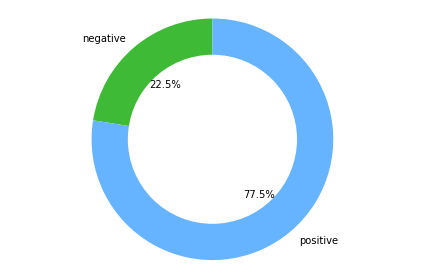

In [ ]:
labels = list(GroupbyLabel.keys())
sizes = list(GroupbyLabel.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
plt.show()

### Blanced DS
We can cut the dataset randomly based on the fewer label (Negative), to make it blanced.
But note that this make DS smaller :(

In [ ]:
negative_data = data[data['label'] == 'negative']
positive_data = data[data['label'] == 'positive']

cutting_point = min(len(negative_data), len(positive_data))

if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

new_data = pd.concat([negative_data, positive_data])
new_data = new_data.sample(frac=1).reset_index(drop=True)# we shuffle the order of the DataFrame's rows,
                                                          # so that all Type's are mixed.
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4110 entries, 0 to 4109
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4110 non-null   object
 1   label    4110 non-null   object
dtypes: object(2)
memory usage: 64.3+ KB


In [ ]:
# See the data number of sentence in each category and is it balanced?
GroupbyLabel = new_data.groupby('label')['label'].count()

GroupbyLabel = dict(GroupbyLabel)
print(GroupbyLabel)

{'negative': 2055, 'positive': 2055}


In [ ]:
new_data.head()

,comment,label
0,عکسبرداری با این دوربین بسیار ساده است ، فقط ک...,positive
1,باز هم ، آیفون بهترین گوشی جهان بود ، اما نکته...,positive
2,از جمله باتري، دوربين عکاسي کم کيفيت جنس بد بد...,negative
3,به خاطر داشته باشید که تمرکز اصلی نوکیا روی کی...,positive
4,چرا که تبلت surface rt برای استفاده های معمولی...,negative


# Train,Validation,Test split

We need to split the balanced cleaned dataset into train, valid and test sets due to size of the data. 

In this tutorial, we have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, we use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [ ]:
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(3329, 3)
(370, 3)
(411, 3)


In [ ]:
new_data.head()

,comment,label,label_id
0,عکسبرداری با این دوربین بسیار ساده است ، فقط ک...,positive,1
1,باز هم ، آیفون بهترین گوشی جهان بود ، اما نکته...,positive,1
2,از جمله باتري، دوربين عکاسي کم کيفيت جنس بد بد...,negative,0
3,به خاطر داشته باشید که تمرکز اصلی نوکیا روی کی...,positive,1
4,چرا که تبلت surface rt برای استفاده های معمولی...,negative,0


## Using PyTorch

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

### Configuration

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 5
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())


{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



### Input Embeddings

In [ ]:
idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['comment']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_comment}\n{sample_label}')

Sample: 
حیف است که این گوشی حافظه جانبی نداشته باشد!
negative


In [ ]:
tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  Comment: حیف است که این گوشی حافظه جانبی نداشته باشد!
   Tokens: حیف است که این گوشی حافظه جانبی نداشته باشد !
Token IDs: [23317, 2806, 2800, 2802, 4013, 5738, 7423, 5102, 3048, 1001]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2, 23317,  2806,  2800,  2802,  4013,  5738,  7423,  5102,  3048,
          1001,     4,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


### Dataset

In [ ]:
class TranslationDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Translation DeepSP Dataset. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TranslationDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['در کل ، همانطور که گفتیم ، m50 یکی دیگر از دوربین فیلمبرداری بسیار خوب از canon است که در عین استفاده از ویژگی های فناوری پیشرفته ، از نظر سبک بسیار کمی است.', 'به نظرم از لحاظ قيمتي اگر در حد نوت بود خوب بود.', 'اگرچه عملکرد کلی صفحه نمایش جدید ipad هنوز در بین تبلت ها برتر است ، اما در واقع از نظر هر دوی آنها باید بگوییم که عملکرد صفحه نمایش surface حتی با نسبت تصویر 16: 9 بسیار خوب است. در مقایسه با نسبت تصویر 4: 3 آیپد ، ابعاد بزرگتر تصاویر را ارائه می دهد.', 'baslam متاسفانه در معرفی این محصول یکی از مهمترین ویژگی های آن عدم توجه به تناسب اندام است.', 'برای خلاصه کردن ، باید بگوییم که برخی از ویژگی های این تبلت تاکنون بی نظیر است.', '2.روشنايي صفحش خيلي کمه.', 'البته لازم به ذکر است که این گوشی نسبت به ابعادی که دارد، بسیار قطور بوده ضخامت زیادی (14 میلی\u200cمتر) دارد.', 'گرافيکش چندان قوي نيست ميتونست قوي تر باشه', 'به هر صورت به نظر می رسد برای مبتدیانی که به کار کردن با نمایشگرهای لمسی گوشی ها

In [ ]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids'])


### Model

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Tue Jul  6 11:34:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
# sample data output

sample_data_comment = sample_data['comment']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)


# outputs = F.softmax(
#     pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids), 
#     dim=1)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(outputs[:5, :])
print(preds[:5])

tensor([[ 0.4803,  0.3638],
        [ 0.1766, -0.4871],
        [ 0.0697, -0.1898],
        [ 0.6020,  0.2984],
        [-0.1018, -0.1889]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0, 0, 0, 0, 0], device='cuda:0')


### Training

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)


Epoch: 5/5...Step: 1000...Train Loss: 0.010552...Train Acc: 0.998...Valid Loss: 0.399946...Valid Acc: 0.903...
Validation loss decreased (inf --> 0.399946).  Saving model ...



### Prediction

In [ ]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)


(411,) (411, 2)


In [ ]:
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.8734478518923732

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87       205
    positive       0.86      0.89      0.88       206

    accuracy                           0.87       411
   macro avg       0.87      0.87      0.87       411
weighted avg       0.87      0.87      0.87       411



## Using TensorFlow

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features

import tensorflow as tf

### Configuration

In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 5
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



### Input Embeddings / Dataset

In [ ]:
class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)
        
        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]
        
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    
    features = glue_convert_examples_to_features(
        examples, 
        tokenizer, 
        maxlen, 
        output_mode=output_mode, 
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features
    
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

In [ ]:
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=128)
valid_dataset_base, valid_examples = make_examples(tokenizer, x_valid, y_valid, maxlen=128)

test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128, is_tf_dataset=False)

In [ ]:
for value in train_dataset_base.take(1):
    print(f'     input_ids: {value[0]["input_ids"]}')
    print(f'attention_mask: {value[0]["attention_mask"]}')
    print(f'token_type_ids: {value[0]["token_type_ids"]}')
    print(f'        target: {value[1]}')

     input_ids: [    2  2786  3142  1348  5785  2800 10709  1348     1  3036  2972  2791
  4834  8281  3177  4124  2791 82098  2806  2800  2786  5266  2988  2791
  4274  6343  4066  6783  1348  2791  3138  4523  3177  3744  2806  1012
     4     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
attention_mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)
valid_dataset = get_training_dataset(valid_dataset_base, VALID_BATCH_SIZE)

train_steps = len(train_examples) // TRAIN_BATCH_SIZE
valid_steps = len(valid_examples) // VALID_BATCH_SIZE

train_steps, valid_steps

(208, 23)

### Model

In [ ]:
def build_model(model_name, config, learning_rate=3e-5):
    model = TFBertForSequenceClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [ ]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [ ]:
%%time

r = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    epochs=EPOCHS,
    verbose=1)

final_accuracy = r.history['val_accuracy']
print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

Epoch 1/5
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
208/208 [==============================] - 114s 473ms/step - loss: 0.4075 - accuracy: 0.8164 - val_loss: 0.2501 - val_accuracy: 0.8913
Epoch 2/5
208/208 [==============================] - 96s 460ms/step - loss: 0.2263 - accuracy: 0.9129 - val_loss: 0.2348 - val_accuracy: 0.9076
Epoch 3/5
208/208 [==============================] - 96s 460ms/step - loss: 0.1009 - accuracy: 0.9654 - val_loss: 0.3015 - val_accuracy: 0.9103
Epoch 4/5
208/208 [==============================] - 95s 459ms/step - loss: 0.0635 - accuracy: 0.9781 - val_loss: 0.4007 - val_accuracy: 0.9076
Epoch 5/5
208/208 [==============================] - 96s 459ms/step - loss: 0.0512 - accuracy: 0.9829 - val_loss: 0.2762 - val_accuracy: 0.8940
FINAL ACCURACY MEAN:  0.902173912525177
CPU times: user 2min 34s, sys: 1min, total: 3min 35s
Wall time: 8min 37s


In [ ]:
# save the model
model.save_pretrained(os.path.dirname(OUTPUT_PATH))

### Evaluation / Prediction

In [ ]:
ev = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
print()
print(f'Evaluation: {ev}')
print()

predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print()
print(classification_report(ytest, ypred, target_names=labels))
print()

print(f'F1: {f1_score(ytest, ypred, average="weighted")}')

26/26 [==============================] - 4s 147ms/step - loss: 0.3330 - accuracy: 0.8832

Evaluation: [0.3330109417438507, 0.8832116723060608]


              precision    recall  f1-score   support

    negative       0.87      0.90      0.88       205
    positive       0.90      0.87      0.88       206

    accuracy                           0.88       411
   macro avg       0.88      0.88      0.88       411
weighted avg       0.88      0.88      0.88       411


F1: 0.8831909344116744


# Source
[Loading a csv file from GitHub in Python](https://medium.com/towards-entrepreneurship/importing-a-csv-file-from-github-in-a-jupyter-notebook-e2c28e7e74a5)